In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

#from tensorflow.keras import layers
#from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
#from sklearn.preprocessing import OneHotEncoder

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


tf.__version__

2023-11-10 11:30:32.702170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-10 11:30:32.798554: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-10 11:30:33.217849: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-10 11:30:33.217892: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [2]:
# Load dataset
csv_file = '../../Datasets/dataset_Halogenos.csv'
#csv_file = '../Dataset/dataset_augmented.csv'
#csv_file = '../Dataset/dataset_left.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R,lambd
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,2,484.4822,350.23
1,0,2,0,0,0,4,0,0,0,0,0,3,0,0,0,0,3,566.3740,353.40
2,0,0,0,0,0,0,0,3,0,0,3,3,4,2,0,0,5,115.5001,359.97
3,0,4,0,4,0,0,0,0,0,0,0,2,0,0,3,3,5,521.1104,369.31
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,2,774.6917,347.50


In [3]:
# remove data with 5 and 6 substituents

dataframe = dataframe_raw.copy()
dataframe = dataframe[ dataframe['Nsubs']<=4 ]

In [4]:
#dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,484.4822
1,0,2,0,0,0,4,0,0,0,0,0,3,0,0,0,0,566.3740
4,0,0,0,0,0,0,0,0,0,0,0,0,0,2,4,0,774.6917
6,0,0,0,0,0,0,0,2,1,0,0,0,0,0,3,3,644.6140
7,0,0,0,2,0,0,4,0,0,0,0,0,4,0,0,2,311.9589


1
32
151
202
209
0
0


Text(0, 0.5, 'count')

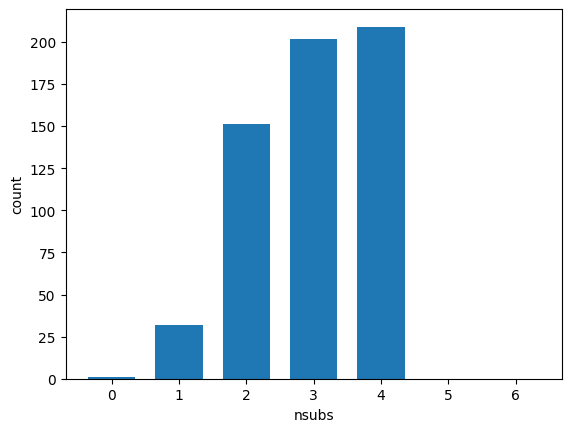

In [5]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
n5 = nsubs.count(5)
n6 = nsubs.count(6)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)
print(n5)
print(n6)

bin_edges = np.arange(-0.5,6.5+1,1)
#bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)
plt.xlabel('nsubs')
plt.ylabel('count')

In [6]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,595.0,0.410084,1.003311,0.0000,0.0000,0.0000,0.0000,4.0000
Pos2,595.0,0.505882,1.124213,0.0000,0.0000,0.0000,0.0000,4.0000
Pos3,595.0,0.450420,1.053523,0.0000,0.0000,0.0000,0.0000,4.0000
Pos4,595.0,0.521008,1.150675,0.0000,0.0000,0.0000,0.0000,4.0000
Pos5,595.0,0.512605,1.152260,0.0000,0.0000,0.0000,0.0000,4.0000
Pos6,595.0,0.433613,1.050996,0.0000,0.0000,0.0000,0.0000,4.0000
Pos7,595.0,0.386555,0.975364,0.0000,0.0000,0.0000,0.0000,4.0000
Pos8,595.0,0.484034,1.099892,0.0000,0.0000,0.0000,0.0000,4.0000
Pos9,595.0,0.480672,1.092157,0.0000,0.0000,0.0000,0.0000,4.0000
Pos10,595.0,0.458824,1.074452,0.0000,0.0000,0.0000,0.0000,4.0000


/tmp/ipykernel_327451/2418938743.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataframe[['target']])


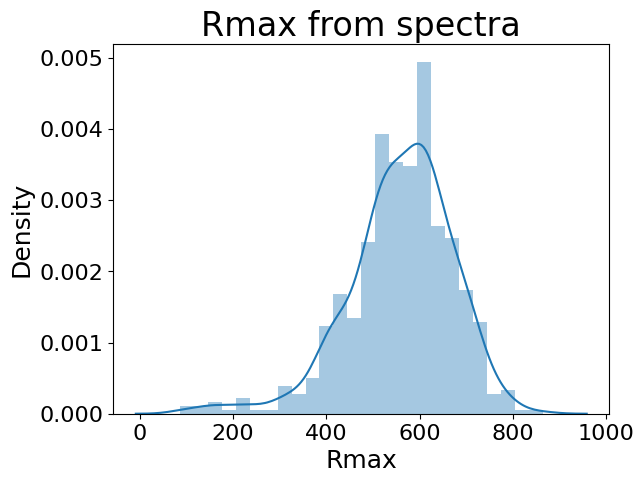

In [7]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set

#sns.pairplot(dataframe[['target']], diag_kind='kde')
#sns.set_style('darkgrid')
sns.distplot(dataframe[['target']])
plt.title('Rmax from spectra',fontsize=24)
plt.xlabel('Rmax',fontsize=18)
plt.ylabel('Density',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Rmax')

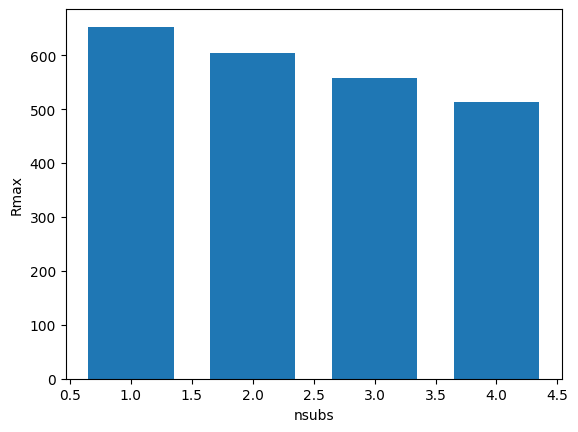

In [8]:
# Rmax as a function of nsubs
Rmax = []
Rmax[:] = dataframe['target']

nsubs1 = [i for i in range(len(nsubs)) if nsubs[i]==1]
nsubs2 = [i for i in range(len(nsubs)) if nsubs[i]==2]
nsubs3 = [i for i in range(len(nsubs)) if nsubs[i]==3]
nsubs4 = [i for i in range(len(nsubs)) if nsubs[i]==4]
nsubs5 = [i for i in range(len(nsubs)) if nsubs[i]==5]
nsubs6 = [i for i in range(len(nsubs)) if nsubs[i]==6]

Rmax1 = [Rmax[i] for i in nsubs1]
Rmax2 = [Rmax[i] for i in nsubs2]
Rmax3 = [Rmax[i] for i in nsubs3]
Rmax4 = [Rmax[i] for i in nsubs4]
Rmax5 = [Rmax[i] for i in nsubs5]
Rmax6 = [Rmax[i] for i in nsubs6]

Rmax1_mean = np.mean(Rmax1)
Rmax2_mean = np.mean(Rmax2)
Rmax3_mean = np.mean(Rmax3)
Rmax4_mean = np.mean(Rmax4)
Rmax5_mean = np.mean(Rmax5)
Rmax6_mean = np.mean(Rmax6)

Rmax_mean = [Rmax1_mean, Rmax2_mean, Rmax3_mean, Rmax4_mean, Rmax5_mean, Rmax6_mean]
#Rmax_mean = [Rmax1_mean, Rmax2_mean, Rmax3_mean, Rmax4_mean]

bin_edges = np.arange(1.5,6.5+1,1)
plt.bar([1,2,3,4,5,6],Rmax_mean, width=0.7)
#bin_edges = np.arange(1.5,4.5+1,1)
#plt.bar([1,2,3,4],Rmax_mean, width=0.7)
plt.xlabel('nsubs')
plt.ylabel('Rmax')


In [9]:
# remove data with R~8

#dataframe = dataframe[ dataframe['target']>10 ]
#dataframe.describe().transpose()

""" # remove data with target<Rmin
Rmin = 380
dataframe = dataframe[ dataframe['target']>Rmin ]
print(dataframe.describe().transpose()) """

" # remove data with target<Rmin\nRmin = 380\ndataframe = dataframe[ dataframe['target']>Rmin ]\nprint(dataframe.describe().transpose()) "

In [10]:
# normalize numerical targets

#R_mean = dataframe['target'].mean()
#R_std = dataframe['target'].std()

# We use mean and std dev from all data, including 1 to 6 substituents
R_mean = 508.891242
R_std = 132.289757

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,595.0,0.410084,1.003311,0.000000,0.000000,0.000000,0.000000,4.000000
Pos2,595.0,0.505882,1.124213,0.000000,0.000000,0.000000,0.000000,4.000000
Pos3,595.0,0.450420,1.053523,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,595.0,0.521008,1.150675,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,595.0,0.512605,1.152260,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,595.0,0.433613,1.050996,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,595.0,0.386555,0.975364,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,595.0,0.484034,1.099892,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,595.0,0.480672,1.092157,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,595.0,0.458824,1.074452,0.000000,0.000000,0.000000,0.000000,4.000000


In [11]:
# One-hot encode inpute features manually 
n_data = dataset.shape[0]
n_atom_types = 5   # (H,Fl,Cl,Br,I)
#n_atom_types = 6   # (H,OH,OMe,SH,SMe,NH2)
#n_atom_types = 5   # (H,CN,CHO,COOH,NO2)
n_pos = 16         # 6-helicenes have 16 possible positions to be occupied
n_features = int(n_atom_types*n_pos)
x_data = np.zeros( (n_data, n_features) )
y_data = np.zeros(n_data)

n_labels = 1
data = np.zeros( (n_data, n_features+n_labels) )

dataset_np = dataset.to_numpy()
#print(dataset_np.shape)
for i in range(n_data):
    for j in range(n_pos):
        atom_id = int(dataset_np[i,j])
        x_data[i,j*n_atom_types+atom_id] = 1.0

    #print(x_data[i,:])
    #print(dataset_np[i,:16])

    y_data[i] = dataset_np[i,n_pos]

    data[i,0:n_features] = x_data[i,:] 
    data[i,n_features] = y_data[i]

print(x_data.shape)
print(y_data.shape)
print(data.shape)


(595, 80)
(595,)
(595, 81)


In [12]:
# function to return N-body model 

def model_Nb(learning_rate=0.01):

    # Non-linear N-body model with single input

    inputs_1b = tf.keras.Input(shape=(None,n_features),name='Molecule')

    # Split the input vector into differents positions with cropping
    inputs_1b_aux = tf.keras.layers.Reshape((n_features,1), input_shape=(n_features,),name='Molecule_aux')(inputs_1b)

    # -------------------------------------------------------------------
    # 1-body term
    # -------------------------------------------------------------------
    print()
    print('1-BODY')

    single_position = []
    for i in range(n_pos):
        init = i * n_atom_types
        end = init + n_atom_types
        left_crop = init
        right_crop = n_features - end
        pos_i = tf.keras.layers.Cropping1D(cropping=(left_crop,right_crop),name='Pos_'+str(i))(inputs_1b_aux)
        print(pos_i)
        single_position.append(pos_i)

    # Define architecture of 1-body models
    def model_1body():
        inputs = tf.keras.Input( shape=(n_atom_types,) )
        outputs = tf.keras.layers.Dense(1,use_bias=False,kernel_initializer='random_normal',name='1B_'+str(i))(inputs)
        return tf.keras.Model(inputs,outputs, name='1B_'+str(i))

    # save 8 models into a list
    models_1b = []
    for i in range(int(n_pos/2)):
        model_i = model_1body()
        models_1b.append(model_i)

    # Apply each model to each position
    outputs_1b = []
    # Positions 1-8
    for i in range(int(n_pos/2)):
        output_i = models_1b[i]( single_position[i] )
        outputs_1b.append( output_i )
    # Positions 9-16
    for i in range(int(n_pos/2),n_pos):
        output_i = models_1b[n_pos-1-i]( single_position[i] )
        outputs_1b.append( output_i )    
    print(len(outputs_1b))

    # -------------------------------------------------------------------
    # N-body term
    # -------------------------------------------------------------------
    print()
    print('N-BODY')

    # reverse molecule
    outputs_1b_rev = []
    for i in range(n_pos):
        outputs_1b_rev.append( outputs_1b[n_pos-i-1] ) 
    #print(outputs_1b_rev)

    x = tf.keras.layers.Concatenate(name='Concatenate')(outputs_1b)
    x_rev = tf.keras.layers.Concatenate(name='Concatenate_inv')(outputs_1b_rev) 

    # Define architecture of N-body non-linear model
    def NN_model():
        inputs = tf.keras.Input( shape=(n_pos,) )
        """ output = tf.keras.layers.Dense(units=256, activation='relu',
                                   #kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                   kernel_initializer='random_normal',
                                   bias_initializer='zeros')(inputs)
        output = tf.keras.layers.Dropout(0.5)(output) """
        """ output = tf.keras.layers.Dense(units=256, activation='relu',
                                   #kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                   kernel_initializer='random_normal',
                                   bias_initializer='zeros')(output)
        output = tf.keras.layers.Dropout(0.5)(output) """

        output = tf.keras.layers.Dense(units=512, activation='relu',
                                   kernel_regularizer=tf.keras.regularizers.l2(0.0001),
                                   kernel_initializer='random_normal',
                                   bias_initializer='zeros')(inputs)
        output = tf.keras.layers.Dropout(0.5)(output)

        #output = tf.keras.layers.Dense(units=256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs)
        #output = tf.keras.layers.Dropout(0.5)(output)
        #output = tf.keras.layers.Dense(units=256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(output)
        #output = tf.keras.layers.Dropout(0.5)(output)
        #output = tf.keras.layers.Dense(units=128, activation='relu')(inputs)
        #output = tf.keras.layers.Dropout(0.5)(output)
        #output = tf.keras.layers.Dense(units=128, activation='relu')(output)
        #output = tf.keras.layers.Dropout(0.5)(output)
        output = tf.keras.layers.Dense(1)(output)
        return tf.keras.Model(inputs,output,name='N-body')

    non_linear_model = NN_model()

    # Apply non-linear model to the molecule and its symmetric
    NN_output1 = non_linear_model(x)
    NN_output2 = non_linear_model(x_rev)

    global_output = tf.keras.layers.Add(name='SUM')([NN_output1,NN_output2])
    print(global_output)

    #R_1b = tf.keras.layers.Add(name='R_1B')(outputs_1b)
    #R_Nb = tf.keras.layers.Add(name='R_NB')([NN_output1,NN_output2])
    #global_output = tf.keras.layers.Add(name='SUM')([R_1b, R_Nb])
    #print(global_output)

    #output = tf.keras.layers.Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.0001))(inputs_1b)
    #output = tf.keras.layers.Dropout(0.5)(output)
    #global_output = tf.keras.layers.Dense(1)(output)

    model = tf.keras.Model(inputs=inputs_1b,outputs=global_output)
    model.summary()
    tf.keras.utils.plot_model(model, "./Models/Nbody_invariant_model.png", show_shapes=True)

    #learning_rate = 0.01
    model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss='mean_absolute_error')

    return model

In [13]:
# function to plot predictions on train and test sets

def plot_pred_true(y_true_train,y_pred_train,y_true_test,y_pred_test,i_CV=0):

    plt.figure(figsize=(3, 3), dpi=200)
    plt.title("Regression of R, CV"+str(i_CV),fontsize=10)
    p1 = min(y_true_train)
    p2 = max(y_true_train)
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
    plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
    #plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
    plt.xlabel('True',fontsize=10)
    plt.ylabel('Pred',fontsize=10)
    plt.legend(loc="upper left",prop={'size': 6})
    plt.show()

In [14]:
# function to compute the error for different nsubs on test set

def error_vs_nsubs(x_test, y_pred_test, y_true_test):

    nsubs_test = np.zeros( x_test.shape[0] )

    # compute number of substitutes for each data test
    for i in range(len(nsubs_test)):

        # for each data, check if first input of every position is an hydrogen
        nsubs_i = 0
        for j in range(n_pos):
            if( x_test[i,j*n_atom_types]==0.0 ): # no hydrogen, hence there is a different substitute
                nsubs_i = nsubs_i+1
        nsubs_test[i] = nsubs_i
    #print(nsubs_test)

    error0 = []
    error1 = []
    error2 = []
    error3 = []
    error4 = []
    error5 = []
    error6 = []
    num_subs = np.zeros(7)
    for i in range(len(nsubs_test)):
        error_i = y_pred_test[i] - y_true_test[i]
        if(nsubs_test[i]==0): 
            error0.append(error_i)
            num_subs[0] +=1
        if(nsubs_test[i]==1): 
            error1.append(error_i)
            num_subs[1] +=1
        if(nsubs_test[i]==2): 
            error2.append(error_i)
            num_subs[2] +=1
        if(nsubs_test[i]==3): 
            error3.append(error_i)
            num_subs[3] +=1
        if(nsubs_test[i]==4): 
            error4.append(error_i)
            num_subs[4] +=1
        if(nsubs_test[i]==5): 
            error5.append(error_i)
            num_subs[5] +=1
        if(nsubs_test[i]==6): 
            error6.append(error_i)
            num_subs[6] +=1

    error_nsubs = np.zeros(7)
    error_nsubs[0] = np.mean(np.abs(error0))
    error_nsubs[1] = np.mean(np.abs(error1))
    error_nsubs[2] = np.mean(np.abs(error2))
    error_nsubs[3] = np.mean(np.abs(error3))
    error_nsubs[4] = np.mean(np.abs(error4))
    error_nsubs[5] = np.mean(np.abs(error5))
    error_nsubs[6] = np.mean(np.abs(error6))

    print(num_subs)
    print(error_nsubs)

    bin_edges = np.arange(1.5,6.5+1,1)
    plt.bar([0,1,2,3,4,5,6],error_nsubs[0:], width=0.7)
    #bin_edges = np.arange(1.5,4.5+1,1)
    #plt.bar([0,1,2,3,4],error_nsubs[0:5], width=0.7)
    plt.xlabel("n_subs",fontsize=16)
    plt.ylabel("MAE",fontsize=16)
    plt.ylim([0,140])
    plt.show()

    return error_nsubs

#error_nsubs = error_vs_nsubs(x_test, y_pred_test, y_true_test)


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

2023-11-10 11:31:06.747657: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-10 11:31:06.771930: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2023-11-10 11:31:06.771953: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-11-10 11:31:06.772301: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neur

Epoch 1/600
107/107 - 1s - loss: 0.5874 - val_loss: 0.4394 - lr: 0.0100 - 944ms/epoch - 9ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4709 - val_loss: 0.4222 - lr: 0.0100 - 91ms/epoch - 852us/step
Epoch 3/600
107/107 - 0s - loss: 0.4301 - val_loss: 0.3691 - lr: 0.0100 - 89ms/epoch - 830us/step
Epoch 4/600
107/107 - 0s - loss: 0.3877 - val_loss: 0.4010 - lr: 0.0100 - 94ms/epoch - 875us/step
Epoch 5/600
107/107 - 0s - loss: 0.3759 - val_loss: 0.4796 - lr: 0.0100 - 93ms/epoch - 872us/step
Epoch 6/600
107/107 - 0s - loss: 0.3746 - val_loss: 0.4450 - lr: 0.0100 - 90ms/epoch - 840us/step
Epoch 7/600
107/107 - 0s - loss: 0.3659 - val_loss: 0.3952 - lr: 0.0100 - 90ms/epoch - 839us/step
Epoch 8/600
107/107 - 0s - loss: 0.3660 - val_loss: 0.4645 - lr: 0.0100 - 95ms/epoch - 884us/step
Epoch 9/600
107/107 - 0s - loss: 0.3654 - val_loss: 0.3298 - lr: 0.0100 - 90ms/epoch - 842us/step
Epoch 10/600
107/107 - 0s - loss: 0.3545 - val_loss: 0.3504 - lr: 0.0100 - 90ms/epoch - 844us/step
Epoch 11/600
107/107

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV0/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV0/assets


15/15 [==============================] - 0s 723us/step


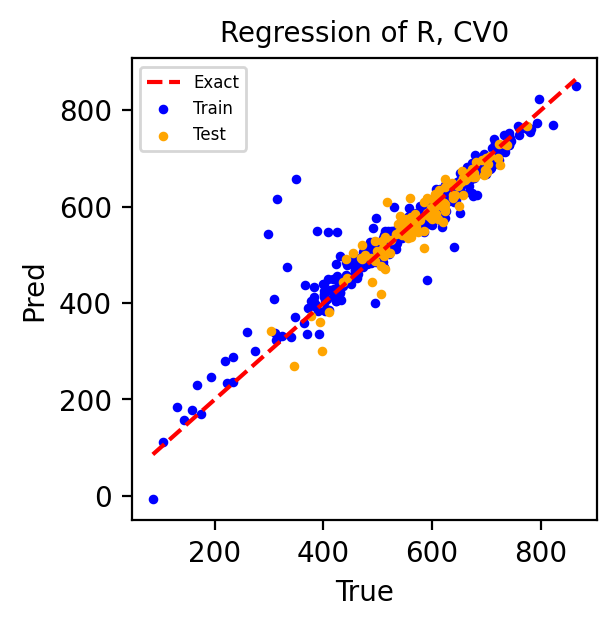

Train MAE (non-normalized): 17.91012216663521
Train RMSE (non-normalized): 34.73908723595935
Train MAPE (non-normalized): 4.1761299216749945
Train R2 (non-normalized): 0.9140313764562147

Test MAE (non-normalized): 20.460851391806724
Test RMSE (non-normalized): 27.76645335506504
Test MAPE (non-normalized): 3.841087945678201
Test R2 (non-normalized): 0.8988671168249346
[ 0.  8. 35. 45. 31.  0.  0.]
[        nan 12.95606514 10.79492595 25.12003299 26.54738393         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


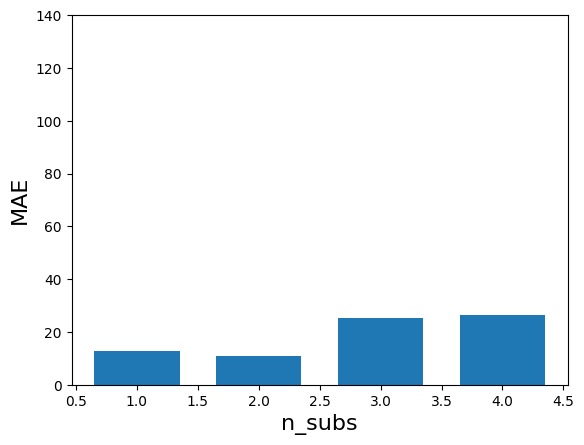


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.5578 - val_loss: 0.4665 - lr: 0.0100 - 860ms/epoch - 8ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4233 - val_loss: 0.3756 - lr: 0.0100 - 87ms/epoch - 815us/step
Epoch 3/600
107/107 - 0s - loss: 0.3878 - val_loss: 0.3552 - lr: 0.0100 - 90ms/epoch - 837us/step
Epoch 4/600
107/107 - 0s - loss: 0.4131 - val_loss: 0.3333 - lr: 0.0100 - 87ms/epoch - 815us/step
Epoch 5/600
107/107 - 0s - loss: 0.3701 - val_loss: 0.3387 - lr: 0.0100 - 86ms/epoch - 801us/step
Epoch 6/600
107/107 - 0s - loss: 0.3530 - val_loss: 0.2662 - lr: 0.0100 - 87ms/epoch - 812us/step
Epoch 7/600
107/107 - 0s - loss: 0.3515 - val_loss: 0.3684 - lr: 0.0100 - 88ms/epoch - 825us/step
Epoch 8/600
107/107 - 0s - loss: 0.3440 - val_loss: 0.3459 - lr: 0.0100 - 86ms/epoch - 806us/step
Epoch 9/600
107/107 - 0s - loss: 0.3362 - val_loss: 0.2854 - lr: 0.0100 - 101ms/epoch - 941us/step
Epoch 10/600
107/107 - 0s - loss: 0.3436 - val_loss: 0.2671 - lr: 0.0100 - 89ms/epoch - 830us/step
Epoch 11/600
107/107 - 0s - los

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV1/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV1/assets


15/15 [==============================] - 0s 739us/step


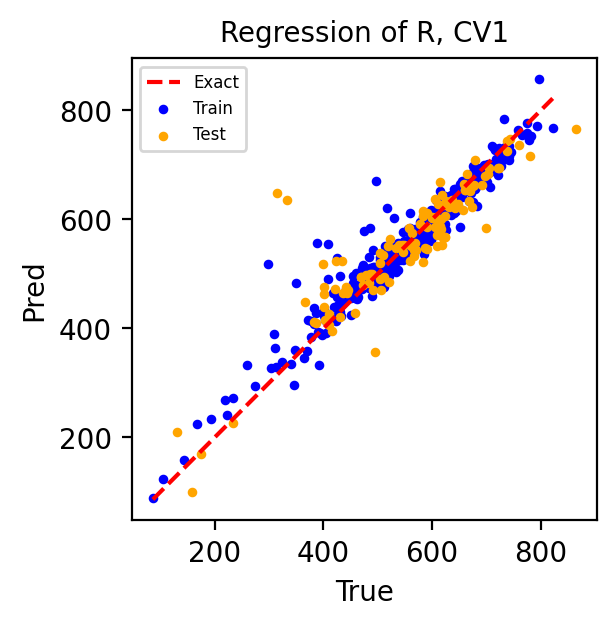

Train MAE (non-normalized): 16.575862994538635
Train RMSE (non-normalized): 28.08669421269476
Train MAPE (non-normalized): 3.490144008950248
Train R2 (non-normalized): 0.9346627020740026

Test MAE (non-normalized): 34.21421889853598
Test RMSE (non-normalized): 56.6846524788648
Test MAPE (non-normalized): 7.661908116448355
Test R2 (non-normalized): 0.7977387487885893
[ 0.  8. 25. 36. 50.  0.  0.]
[        nan 12.00710477 35.95417597 40.06425097 32.68535553         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


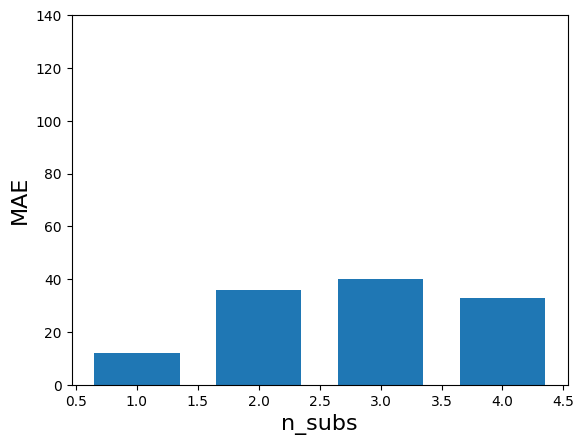


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.5948 - val_loss: 0.6421 - lr: 0.0100 - 916ms/epoch - 9ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4410 - val_loss: 0.5810 - lr: 0.0100 - 92ms/epoch - 861us/step
Epoch 3/600
107/107 - 0s - loss: 0.4022 - val_loss: 0.3339 - lr: 0.0100 - 88ms/epoch - 826us/step
Epoch 4/600
107/107 - 0s - loss: 0.4044 - val_loss: 0.2681 - lr: 0.0100 - 89ms/epoch - 836us/step
Epoch 5/600
107/107 - 0s - loss: 0.3785 - val_loss: 0.3091 - lr: 0.0100 - 91ms/epoch - 846us/step
Epoch 6/600
107/107 - 0s - loss: 0.3734 - val_loss: 0.2752 - lr: 0.0100 - 90ms/epoch - 838us/step
Epoch 7/600
107/107 - 0s - loss: 0.3869 - val_loss: 0.2657 - lr: 0.0100 - 90ms/epoch - 845us/step
Epoch 8/600
107/107 - 0s - loss: 0.3752 - val_loss: 0.2989 - lr: 0.0100 - 88ms/epoch - 826us/step
Epoch 9/600
107/107 - 0s - loss: 0.3344 - val_loss: 0.3205 - lr: 0.0100 - 90ms/epoch - 838us/step
Epoch 10/600
107/107 - 0s - loss: 0.3520 - val_loss: 0.2490 - lr: 0.0100 - 86ms/epoch - 800us/step
Epoch 11/600
107/107 - 0s - loss

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV2/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV2/assets


15/15 [==============================] - 0s 698us/step


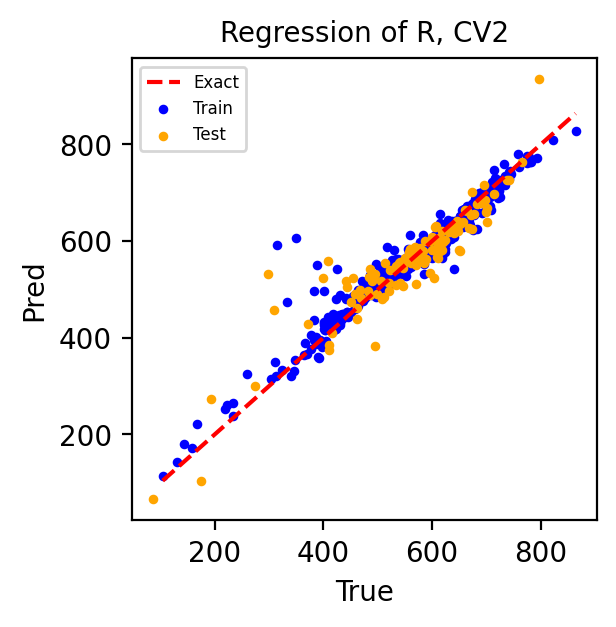

Train MAE (non-normalized): 15.604836121118373
Train RMSE (non-normalized): 28.677724227427586
Train MAPE (non-normalized): 3.3266595563298798
Train R2 (non-normalized): 0.9352295491714703

Test MAE (non-normalized): 30.366128493878023
Test RMSE (non-normalized): 46.095454593656065
Test MAPE (non-normalized): 6.736643282606525
Test R2 (non-normalized): 0.8416750766342739
[ 0.  8. 28. 45. 38.  0.  0.]
[        nan 11.60904989 26.25839446 23.67986217 45.2596855          nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


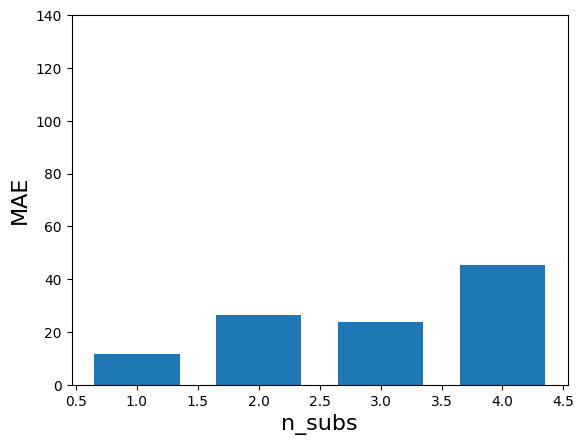


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.5941 - val_loss: 0.4341 - lr: 0.0100 - 815ms/epoch - 8ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4648 - val_loss: 0.4326 - lr: 0.0100 - 86ms/epoch - 805us/step
Epoch 3/600
107/107 - 0s - loss: 0.4166 - val_loss: 0.2978 - lr: 0.0100 - 88ms/epoch - 821us/step
Epoch 4/600
107/107 - 0s - loss: 0.3665 - val_loss: 0.3760 - lr: 0.0100 - 83ms/epoch - 779us/step
Epoch 5/600
107/107 - 0s - loss: 0.3819 - val_loss: 0.3521 - lr: 0.0100 - 83ms/epoch - 778us/step
Epoch 6/600
107/107 - 0s - loss: 0.3851 - val_loss: 0.3219 - lr: 0.0100 - 84ms/epoch - 780us/step
Epoch 7/600
107/107 - 0s - loss: 0.3640 - val_loss: 0.3462 - lr: 0.0100 - 83ms/epoch - 772us/step
Epoch 8/600
107/107 - 0s - loss: 0.3545 - val_loss: 0.3463 - lr: 0.0100 - 84ms/epoch - 786us/step
Epoch 9/600
107/107 - 0s - loss: 0.3470 - val_loss: 0.3337 - lr: 0.0100 - 83ms/epoch - 778us/step
Epoch 10/600
107/107 - 0s - loss: 0.3748 - val_loss: 0.3624 - lr: 0.0100 - 83ms/epoch - 774us/step
Epoch 11/600
107/107 - 0s - loss

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV3/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV3/assets


15/15 [==============================] - 0s 746us/step


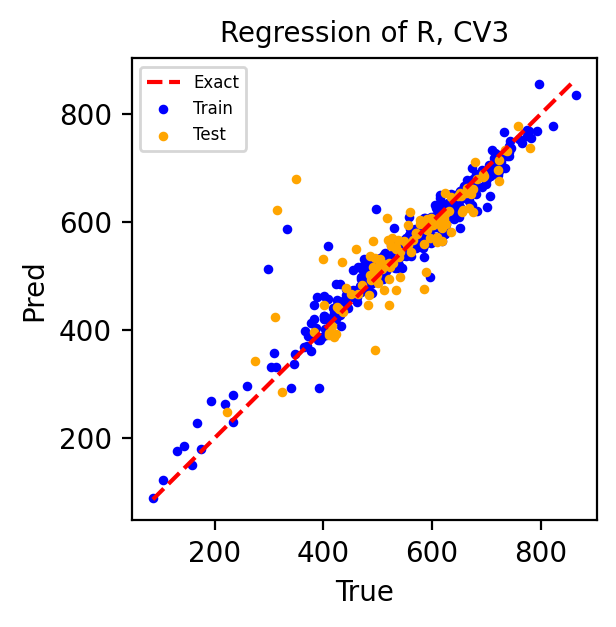

Train MAE (non-normalized): 16.402107730846243
Train RMSE (non-normalized): 27.65178079802769
Train MAPE (non-normalized): 3.4972804045381904
Train R2 (non-normalized): 0.9423773573540031

Test MAE (non-normalized): 32.271206308675815
Test RMSE (non-normalized): 56.527380967241356
Test MAPE (non-normalized): 6.994604500377359
Test R2 (non-normalized): 0.7108485905026094
[ 0.  3. 32. 40. 44.  0.  0.]
[        nan 12.27355199 28.96060504 35.2285017  33.3539424          nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


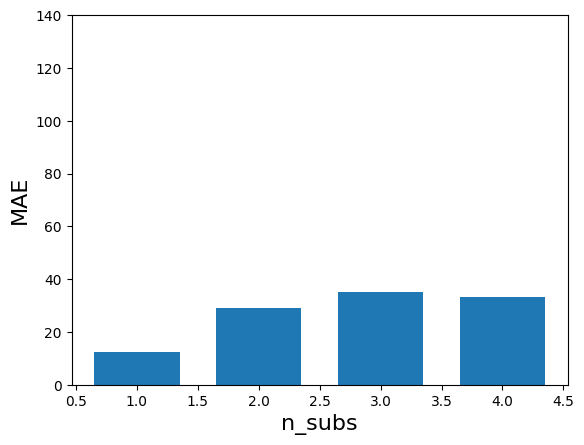


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.5879 - val_loss: 0.5328 - lr: 0.0100 - 943ms/epoch - 9ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4748 - val_loss: 0.4328 - lr: 0.0100 - 90ms/epoch - 845us/step
Epoch 3/600
107/107 - 0s - loss: 0.3939 - val_loss: 0.4473 - lr: 0.0100 - 88ms/epoch - 820us/step
Epoch 4/600
107/107 - 0s - loss: 0.3997 - val_loss: 0.3775 - lr: 0.0100 - 86ms/epoch - 806us/step
Epoch 5/600
107/107 - 0s - loss: 0.3705 - val_loss: 0.3308 - lr: 0.0100 - 88ms/epoch - 820us/step
Epoch 6/600
107/107 - 0s - loss: 0.3473 - val_loss: 0.3104 - lr: 0.0100 - 89ms/epoch - 830us/step
Epoch 7/600
107/107 - 0s - loss: 0.3613 - val_loss: 0.3007 - lr: 0.0100 - 85ms/epoch - 797us/step
Epoch 8/600
107/107 - 0s - loss: 0.3596 - val_loss: 0.3536 - lr: 0.0100 - 90ms/epoch - 844us/step
Epoch 9/600
107/107 - 0s - loss: 0.3288 - val_loss: 0.3390 - lr: 0.0100 - 88ms/epoch - 820us/step
Epoch 10/600
107/107 - 0s - loss: 0.3566 - val_loss: 0.2903 - lr: 0.0100 - 89ms/epoch - 828us/step
Epoch 11/600
107/107 - 0s - loss

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV4/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV4/assets


15/15 [==============================] - 0s 763us/step


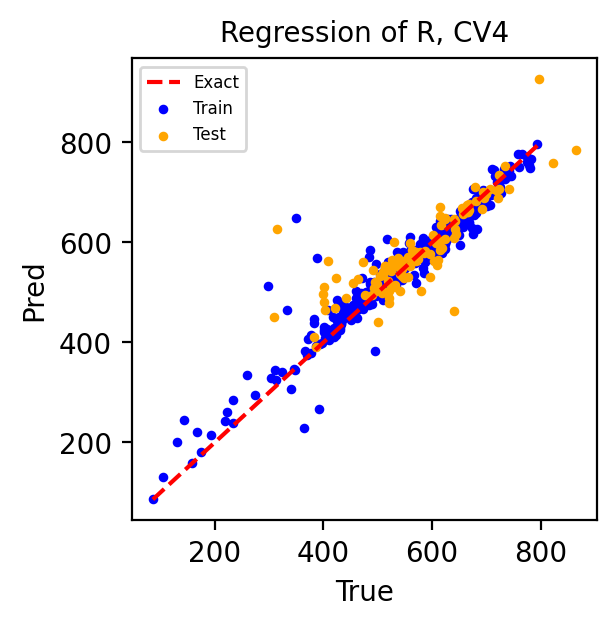

Train MAE (non-normalized): 16.466065153644468
Train RMSE (non-normalized): 30.07029766936177
Train MAPE (non-normalized): 3.7050763084927754
Train R2 (non-normalized): 0.9332193436024216

Test MAE (non-normalized): 32.750484966271664
Test RMSE (non-normalized): 52.89603688480614
Test MAPE (non-normalized): 6.64942475858931
Test R2 (non-normalized): 0.7147409936084068
[ 1.  5. 37. 38. 38.  0.  0.]
[ 0.92674775  8.16533365 24.19927219 30.82907588 47.07043001         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


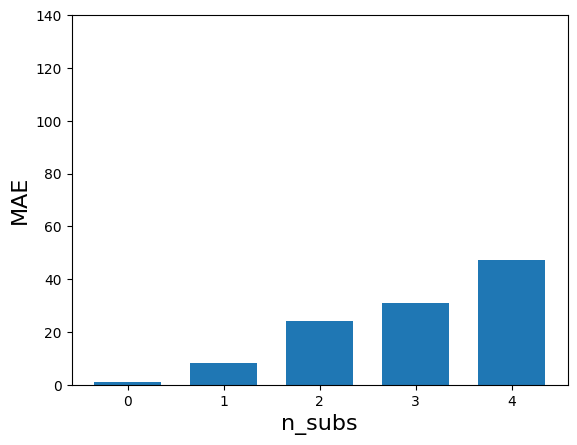


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.6201 - val_loss: 0.4330 - lr: 0.0100 - 863ms/epoch - 8ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4660 - val_loss: 0.3614 - lr: 0.0100 - 90ms/epoch - 838us/step
Epoch 3/600
107/107 - 0s - loss: 0.4148 - val_loss: 0.3121 - lr: 0.0100 - 87ms/epoch - 809us/step
Epoch 4/600
107/107 - 0s - loss: 0.3775 - val_loss: 0.3476 - lr: 0.0100 - 87ms/epoch - 810us/step
Epoch 5/600
107/107 - 0s - loss: 0.3678 - val_loss: 0.3478 - lr: 0.0100 - 88ms/epoch - 819us/step
Epoch 6/600
107/107 - 0s - loss: 0.3609 - val_loss: 0.3445 - lr: 0.0100 - 86ms/epoch - 802us/step
Epoch 7/600
107/107 - 0s - loss: 0.3655 - val_loss: 0.3609 - lr: 0.0100 - 86ms/epoch - 808us/step
Epoch 8/600
107/107 - 0s - loss: 0.3449 - val_loss: 0.2586 - lr: 0.0100 - 89ms/epoch - 828us/step
Epoch 9/600
107/107 - 0s - loss: 0.3357 - val_loss: 0.2430 - lr: 0.0100 - 87ms/epoch - 817us/step
Epoch 10/600
107/107 - 0s - loss: 0.3802 - val_loss: 0.3519 - lr: 0.0100 - 88ms/epoch - 819us/step
Epoch 11/600
107/107 - 0s - loss

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV5/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV5/assets


15/15 [==============================] - 0s 661us/step


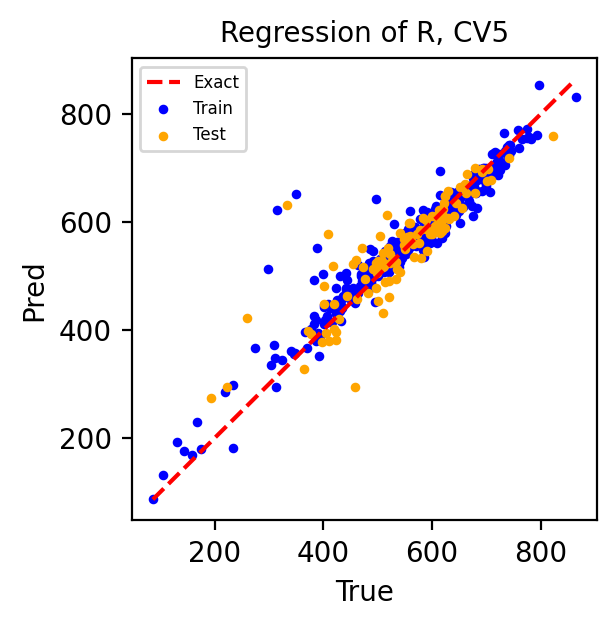

Train MAE (non-normalized): 18.18395778757304
Train RMSE (non-normalized): 33.05373466906613
Train MAPE (non-normalized): 4.003753475269962
Train R2 (non-normalized): 0.9178502319323367

Test MAE (non-normalized): 31.261029218503808
Test RMSE (non-normalized): 49.89811240077155
Test MAPE (non-normalized): 7.014910812144613
Test R2 (non-normalized): 0.7682072724318745
[ 0.  6. 32. 38. 43.  0.  0.]
[        nan 10.44350321 16.93915453 42.19252883 35.16354459         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


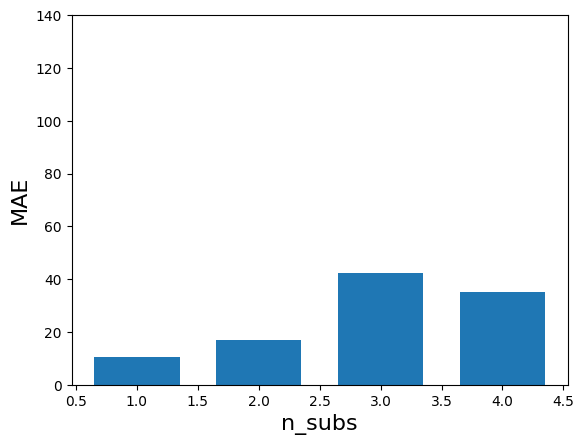


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.5704 - val_loss: 0.4852 - lr: 0.0100 - 952ms/epoch - 9ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4642 - val_loss: 0.4938 - lr: 0.0100 - 97ms/epoch - 904us/step
Epoch 3/600
107/107 - 0s - loss: 0.4068 - val_loss: 0.5374 - lr: 0.0100 - 92ms/epoch - 862us/step
Epoch 4/600
107/107 - 0s - loss: 0.3883 - val_loss: 0.3552 - lr: 0.0100 - 94ms/epoch - 874us/step
Epoch 5/600
107/107 - 0s - loss: 0.4009 - val_loss: 0.4662 - lr: 0.0100 - 93ms/epoch - 870us/step
Epoch 6/600
107/107 - 0s - loss: 0.3784 - val_loss: 0.3850 - lr: 0.0100 - 94ms/epoch - 877us/step
Epoch 7/600
107/107 - 0s - loss: 0.3773 - val_loss: 0.3323 - lr: 0.0100 - 93ms/epoch - 871us/step
Epoch 8/600
107/107 - 0s - loss: 0.3576 - val_loss: 0.3610 - lr: 0.0100 - 90ms/epoch - 839us/step
Epoch 9/600
107/107 - 0s - loss: 0.3621 - val_loss: 0.2975 - lr: 0.0100 - 95ms/epoch - 890us/step
Epoch 10/600
107/107 - 0s - loss: 0.3162 - val_loss: 0.3463 - lr: 0.0100 - 91ms/epoch - 855us/step
Epoch 11/600
107/107 - 0s - loss

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV6/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV6/assets


15/15 [==============================] - 0s 722us/step


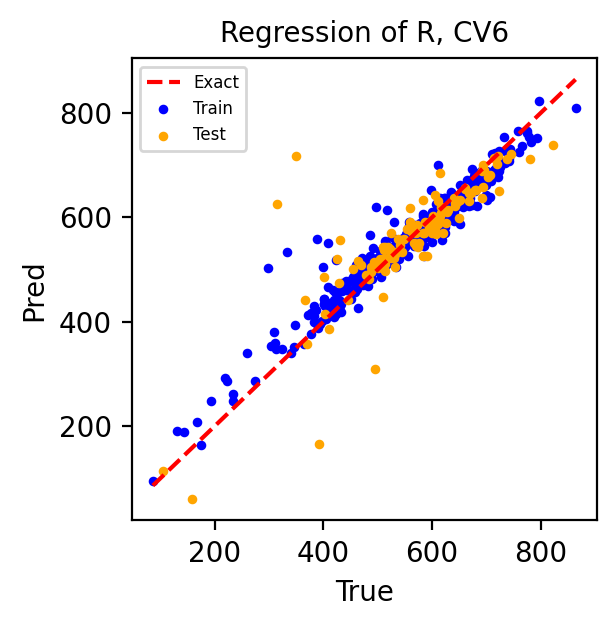

Train MAE (non-normalized): 19.466513427118894
Train RMSE (non-normalized): 30.14797853655235
Train MAPE (non-normalized): 4.132741389250635
Train R2 (non-normalized): 0.9303303312869654

Test MAE (non-normalized): 33.241166388606224
Test RMSE (non-normalized): 61.908270876486384
Test MAPE (non-normalized): 7.315653629974168
Test R2 (non-normalized): 0.6803371217014867
[ 0.  7. 33. 47. 32.  0.  0.]
[        nan 11.40060935 28.82462666 33.83082198 41.70728819         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


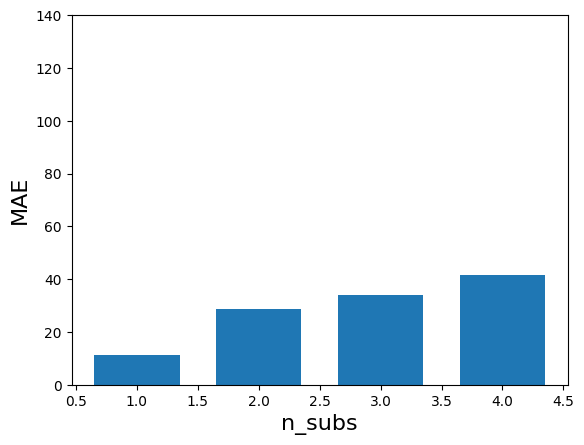


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.5764 - val_loss: 0.5352 - lr: 0.0100 - 1s/epoch - 10ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4845 - val_loss: 0.2674 - lr: 0.0100 - 96ms/epoch - 898us/step
Epoch 3/600
107/107 - 0s - loss: 0.3942 - val_loss: 0.2152 - lr: 0.0100 - 94ms/epoch - 875us/step
Epoch 4/600
107/107 - 0s - loss: 0.3772 - val_loss: 0.4170 - lr: 0.0100 - 93ms/epoch - 865us/step
Epoch 5/600
107/107 - 0s - loss: 0.3780 - val_loss: 0.3040 - lr: 0.0100 - 93ms/epoch - 866us/step
Epoch 6/600
107/107 - 0s - loss: 0.3601 - val_loss: 0.2186 - lr: 0.0100 - 100ms/epoch - 932us/step
Epoch 7/600
107/107 - 0s - loss: 0.3445 - val_loss: 0.2213 - lr: 0.0100 - 94ms/epoch - 883us/step
Epoch 8/600
107/107 - 0s - loss: 0.3492 - val_loss: 0.2901 - lr: 0.0100 - 95ms/epoch - 885us/step
Epoch 9/600
107/107 - 0s - loss: 0.3729 - val_loss: 0.2943 - lr: 0.0100 - 93ms/epoch - 866us/step
Epoch 10/600
107/107 - 0s - loss: 0.3643 - val_loss: 0.2566 - lr: 0.0100 - 93ms/epoch - 865us/step
Epoch 11/600
107/107 - 0s - loss:

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV7/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV7/assets


15/15 [==============================] - 0s 724us/step


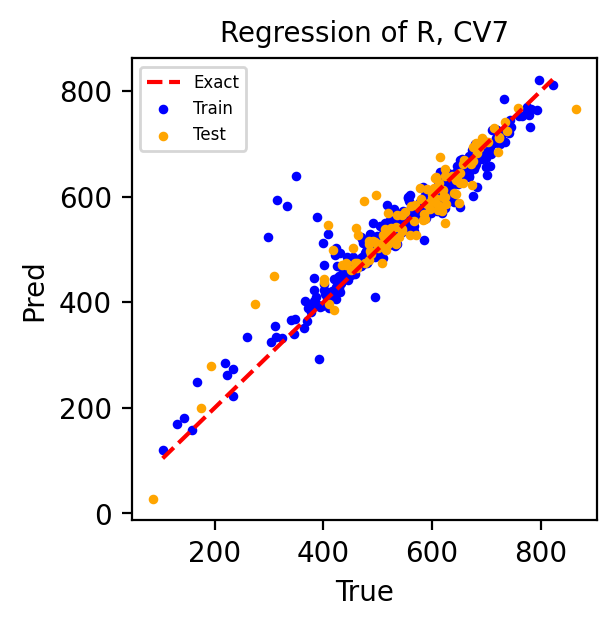

Train MAE (non-normalized): 17.787326273531875
Train RMSE (non-normalized): 34.140254810590385
Train MAPE (non-normalized): 3.9305836888237287
Train R2 (non-normalized): 0.908117399779103

Test MAE (non-normalized): 27.496522623424372
Test RMSE (non-normalized): 39.253398384022944
Test MAPE (non-normalized): 6.261013648162049
Test R2 (non-normalized): 0.8855986185228689
[ 0.  6. 30. 39. 44.  0.  0.]
[        nan 11.42933794 16.52917274 30.93027513 34.12168755         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


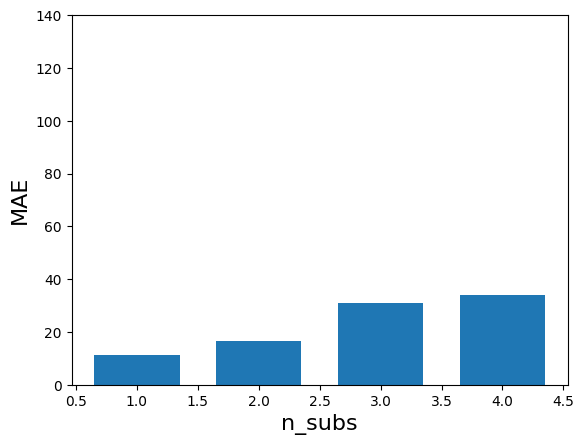


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.5896 - val_loss: 0.6137 - lr: 0.0100 - 913ms/epoch - 9ms/step
Epoch 2/600
107/107 - 0s - loss: 0.4470 - val_loss: 0.5271 - lr: 0.0100 - 93ms/epoch - 867us/step
Epoch 3/600
107/107 - 0s - loss: 0.4018 - val_loss: 0.5097 - lr: 0.0100 - 92ms/epoch - 857us/step
Epoch 4/600
107/107 - 0s - loss: 0.3969 - val_loss: 0.4329 - lr: 0.0100 - 90ms/epoch - 839us/step
Epoch 5/600
107/107 - 0s - loss: 0.3758 - val_loss: 0.3223 - lr: 0.0100 - 91ms/epoch - 848us/step
Epoch 6/600
107/107 - 0s - loss: 0.3679 - val_loss: 0.3162 - lr: 0.0100 - 93ms/epoch - 867us/step
Epoch 7/600
107/107 - 0s - loss: 0.3549 - val_loss: 0.3879 - lr: 0.0100 - 90ms/epoch - 839us/step
Epoch 8/600
107/107 - 0s - loss: 0.3599 - val_loss: 0.3227 - lr: 0.0100 - 90ms/epoch - 841us/step
Epoch 9/600
107/107 - 0s - loss: 0.3481 - val_loss: 0.2965 - lr: 0.0100 - 90ms/epoch - 839us/step
Epoch 10/600
107/107 - 0s - loss: 0.3393 - val_loss: 0.3280 - lr: 0.0100 - 93ms/epoch - 865us/step
Epoch 11/600
107/107 - 0s - loss

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV8/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV8/assets


15/15 [==============================] - 0s 730us/step


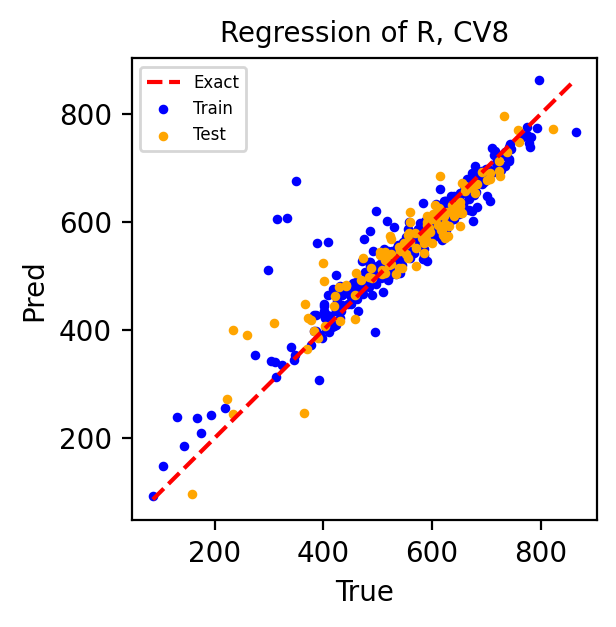

Train MAE (non-normalized): 19.10326921043076
Train RMSE (non-normalized): 36.81113898100027
Train MAPE (non-normalized): 4.301587251682968
Train R2 (non-normalized): 0.8908364065612566

Test MAE (non-normalized): 29.27380005293133
Test RMSE (non-normalized): 40.63579489449205
Test MAPE (non-normalized): 6.618105783456054
Test R2 (non-normalized): 0.8860297349781715
[ 0.  5. 31. 38. 45.  0.  0.]
[        nan  8.32979893 19.0056711  32.24759636 36.16330547         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


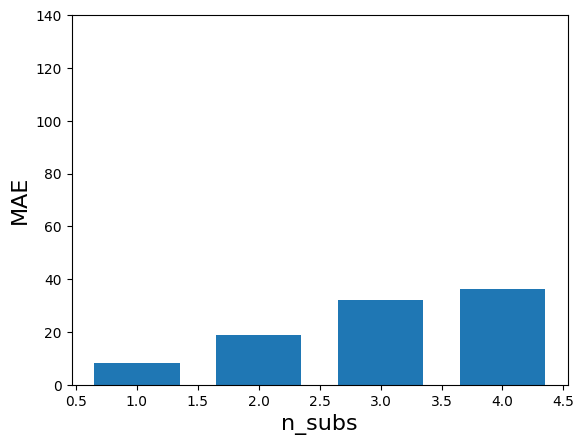


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

107/107 - 1s - loss: 0.6355 - val_loss: 0.4895 - lr: 0.0100 - 915ms/epoch - 9ms/step
Epoch 2/600
107/107 - 0s - loss: 0.5185 - val_loss: 0.3522 - lr: 0.0100 - 93ms/epoch - 872us/step
Epoch 3/600
107/107 - 0s - loss: 0.4193 - val_loss: 0.3838 - lr: 0.0100 - 92ms/epoch - 861us/step
Epoch 4/600
107/107 - 0s - loss: 0.3776 - val_loss: 0.3684 - lr: 0.0100 - 91ms/epoch - 854us/step
Epoch 5/600
107/107 - 0s - loss: 0.3976 - val_loss: 0.3300 - lr: 0.0100 - 316ms/epoch - 3ms/step
Epoch 6/600
107/107 - 0s - loss: 0.3782 - val_loss: 0.3155 - lr: 0.0100 - 117ms/epoch - 1ms/step
Epoch 7/600
107/107 - 0s - loss: 0.3678 - val_loss: 0.2932 - lr: 0.0100 - 96ms/epoch - 898us/step
Epoch 8/600
107/107 - 0s - loss: 0.3479 - val_loss: 0.3244 - lr: 0.0100 - 96ms/epoch - 893us/step
Epoch 9/600
107/107 - 0s - loss: 0.3462 - val_loss: 0.3238 - lr: 0.0100 - 98ms/epoch - 913us/step
Epoch 10/600
107/107 - 0s - loss: 0.3482 - val_loss: 0.3111 - lr: 0.0100 - 95ms/epoch - 890us/step
Epoch 11/600
107/107 - 0s - loss: 

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV9/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_CV9/assets


15/15 [==============================] - 0s 718us/step


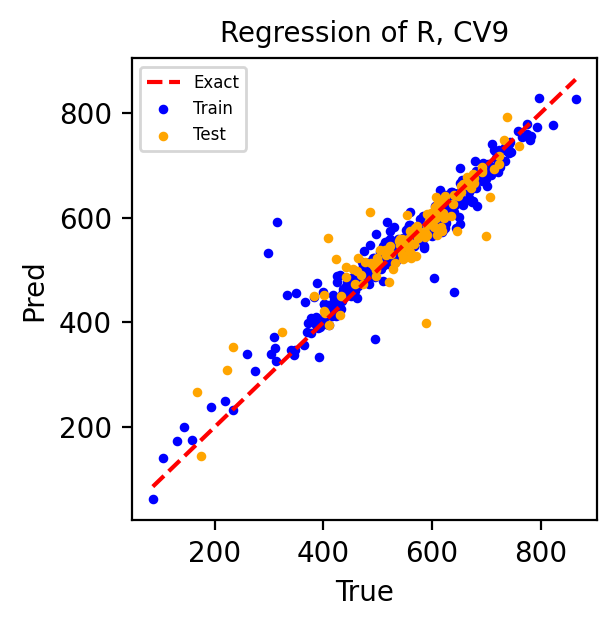

Train MAE (non-normalized): 17.711425762785584
Train RMSE (non-normalized): 30.457915497228093
Train MAPE (non-normalized): 3.8275616387492652
Train R2 (non-normalized): 0.9290578057212326

Test MAE (non-normalized): 27.025547564338243
Test RMSE (non-normalized): 41.86417662670347
Test MAPE (non-normalized): 6.002675362347382
Test R2 (non-normalized): 0.852727851467047
[ 0.  6. 26. 41. 46.  0.  0.]
[        nan  8.18082388 12.00571439 29.86110264 35.44568336         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


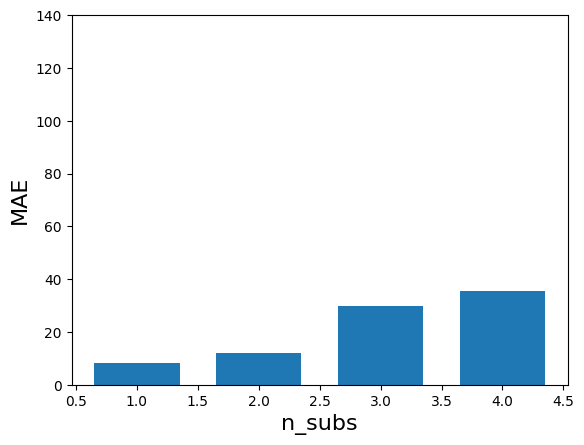

In [15]:
# Cross validation loop 

epochs = 600
batch_size = 4
learning_rate = 0.01
n_crossvalidation = 10

error_nsubs_accu = np.zeros(7)

test_mae_CV = np.zeros(n_crossvalidation)
test_mse_CV = np.zeros(n_crossvalidation)
test_mape_CV = np.zeros(n_crossvalidation)
test_r2_CV = np.zeros(n_crossvalidation)
train_mae_CV = np.zeros(n_crossvalidation)
train_mse_CV = np.zeros(n_crossvalidation)
train_mape_CV = np.zeros(n_crossvalidation)
train_r2_CV = np.zeros(n_crossvalidation)

for i_crossval in range(n_crossvalidation):

    # 1. Split into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42+i_crossval)    

    # 2. Build and compile 1-body model
    model = model_Nb(learning_rate=learning_rate)
    
    # 3. Train the model
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=50, min_lr=1e-8)
    history = model.fit(x=x_train, y=y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

    # Plot the loss
    """ plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    val_loss_per_epoch = history.history['val_loss']
    train_loss_per_epoch = history.history['loss']
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print('Best epoch: %d' % (best_epoch,)) """

    # 4. Save the model
    model.save('./Models/R_model_invariant_1body_CV'+str(i_crossval))
    
    # 5. Evaluate the model with non-normalized units on the whole dataset

    y_pred_test = model.predict(x_test)
    y_true_test = np.zeros((len(y_test),1))
    y_true_test[:,0] = y_test[:]

    y_pred_train = model.predict(x_train)
    y_true_train = np.zeros((len(y_train),1))
    y_true_train[:,0] = y_train[:]

    y_true_test = y_true_test * R_std + R_mean
    y_pred_test = y_pred_test * R_std + R_mean
    y_true_test = y_true_test.ravel()
    y_pred_test = y_pred_test.ravel()

    y_true_train = y_true_train * R_std + R_mean
    y_pred_train = y_pred_train * R_std + R_mean
    y_true_train = y_true_train.ravel()
    y_pred_train = y_pred_train.ravel()

    plot_pred_true(y_true_train,y_pred_train,y_true_test,y_pred_test,i_CV=i_crossval)

    # 6. Compute metrics on non-normalized units
    train_mae = mean_absolute_error(y_true_train,y_pred_train)
    print("Train MAE (non-normalized): "+str(train_mae))
    train_mse = mean_squared_error(y_true_train,y_pred_train,squared=False)
    print("Train RMSE (non-normalized): "+str(train_mse))
    train_mape = mean_absolute_percentage_error(y_true_train,y_pred_train)*100
    print("Train MAPE (non-normalized): "+str(train_mape))
    train_r2 = r2_score(y_true_train,y_pred_train)
    print("Train R2 (non-normalized): "+str(train_r2))

    print()
    test_mae = mean_absolute_error(y_true_test,y_pred_test)
    print("Test MAE (non-normalized): "+str(test_mae))
    test_mse = mean_squared_error(y_true_test,y_pred_test,squared=False)
    print("Test RMSE (non-normalized): "+str(test_mse))
    test_mape = mean_absolute_percentage_error(y_true_test,y_pred_test)*100
    print("Test MAPE (non-normalized): "+str(test_mape))
    test_r2 = r2_score(y_true_test,y_pred_test)
    print("Test R2 (non-normalized): "+str(test_r2))

    test_mae_CV[i_crossval] = test_mae
    test_mse_CV[i_crossval] = test_mse
    test_mape_CV[i_crossval] = test_mape
    test_r2_CV[i_crossval] = test_r2
    train_mae_CV[i_crossval] = train_mae
    train_mse_CV[i_crossval] = train_mse
    train_mape_CV[i_crossval] = train_mape
    train_r2_CV[i_crossval] = train_r2

    # 7. Compute error for different nsubs on test set
    error_nsubs = error_vs_nsubs(x_test, y_pred_test, y_true_test)
    error_nsubs_accu = error_nsubs_accu + error_nsubs

error_nsubs_mean = error_nsubs_accu / n_crossvalidation

In [16]:
# Compute mean and std of metrics with non-normalized units

train_mae_mean = np.mean(train_mae_CV)
train_mse_mean = np.mean(train_mse_CV)
train_mape_mean = np.mean(train_mape_CV)
train_r2_mean = np.mean(train_r2_CV)
test_mae_mean = np.mean(test_mae_CV)
test_mse_mean = np.mean(test_mse_CV)
test_mape_mean = np.mean(test_mape_CV)
test_r2_mean = np.mean(test_r2_CV)

train_mae_std = np.std(train_mae_CV)
train_mse_std = np.std(train_mse_CV)
train_mape_std = np.std(train_mape_CV)
train_r2_std = np.std(train_r2_CV)
test_mae_std = np.std(test_mae_CV)
test_mse_std = np.std(test_mse_CV)
test_mape_std = np.std(test_mape_CV)
test_r2_std = np.std(test_r2_CV)

print("Train MAE (non-normalized): "+str(train_mae_mean)+" +- "+str(train_mae_std))
print("Train RMSE (non-normalized): "+str(train_mse_mean)+" +- "+str(train_mse_std))
print("Train MAPE (non-normalized): "+str(train_mape_mean)+" +- "+str(train_mape_std))
print("Train R2 (non-normalized): "+str(train_r2_mean)+" +- "+str(train_r2_std))

print()
print("Test MAE (non-normalized): "+str(test_mae_mean)+" +- "+str(test_mae_std))
print("Test RMSE (non-normalized): "+str(test_mse_mean)+" +- "+str(test_mse_std))
print("Test MAPE (non-normalized): "+str(test_mape_mean)+" +- "+str(test_mape_std))
print("Test R2 (non-normalized): "+str(test_r2_mean)+" +- "+str(test_r2_std))

Train MAE (non-normalized): 17.521148662822306 +- 1.1796819182304006
Train RMSE (non-normalized): 31.38366066379084 +- 2.9552023743927442
Train MAPE (non-normalized): 3.8391517643762647 +- 0.3112058014407705
Train R2 (non-normalized): 0.9235712503939005 +- 0.014884924597557346

Test MAE (non-normalized): 29.83609559069722 +- 3.8611064882891144
Test RMSE (non-normalized): 47.35297314621097 +- 9.72817337505569
Test MAPE (non-normalized): 6.509602783978401 +- 0.9995350068297323
Test R2 (non-normalized): 0.8036771125460263 +- 0.07709535625506608


[        nan 10.67951787 21.9471713  32.39840486 36.75183065         nan
         nan]


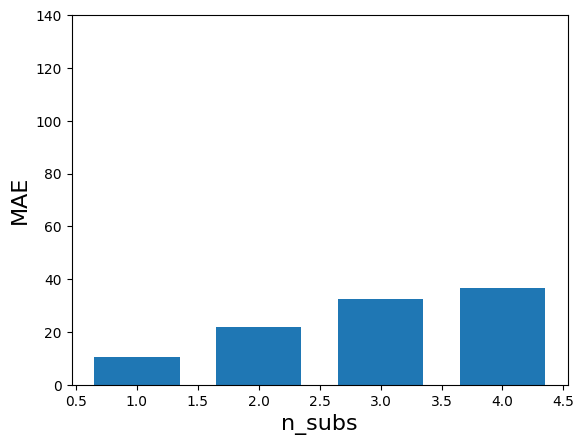

In [18]:
# Mean error vs nsubs

print(error_nsubs_mean)

bin_edges = np.arange(1.5,6.5+1,1)
plt.bar([0,1,2,3,4,5,6],error_nsubs_mean[0:], width=0.7)
#bin_edges = np.arange(1.5,4.5+1,1)
#plt.bar([0,1,2,3,4],error_nsubs[0:5], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.ylim([0,140])
plt.show()


1-BODY
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_0/strided_slice:0', description="created by layer 'Pos_0'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_1/strided_slice:0', description="created by layer 'Pos_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_2/strided_slice:0', description="created by layer 'Pos_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_3/strided_slice:0', description="created by layer 'Pos_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_4/strided_slice:0', description="created by layer 'Pos_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None), name='Pos_5/strided_slice:0', description="created by layer 'Pos_5'")
KerasTensor(type_spec=TensorSpec(shape=(None, 5, 1), dtype=tf.float32, nam

149/149 - 1s - loss: 0.5752 - lr: 0.0100 - 845ms/epoch - 6ms/step
Epoch 2/1000
149/149 - 0s - loss: 0.4171 - lr: 0.0100 - 118ms/epoch - 792us/step
Epoch 3/1000
149/149 - 0s - loss: 0.4001 - lr: 0.0100 - 116ms/epoch - 778us/step
Epoch 4/1000
149/149 - 0s - loss: 0.3861 - lr: 0.0100 - 111ms/epoch - 744us/step
Epoch 5/1000
149/149 - 0s - loss: 0.3741 - lr: 0.0100 - 111ms/epoch - 746us/step
Epoch 6/1000
149/149 - 0s - loss: 0.3440 - lr: 0.0100 - 112ms/epoch - 750us/step
Epoch 7/1000
149/149 - 0s - loss: 0.3623 - lr: 0.0100 - 113ms/epoch - 756us/step
Epoch 8/1000
149/149 - 0s - loss: 0.3475 - lr: 0.0100 - 110ms/epoch - 740us/step
Epoch 9/1000
149/149 - 0s - loss: 0.3420 - lr: 0.0100 - 116ms/epoch - 780us/step
Epoch 10/1000
149/149 - 0s - loss: 0.3447 - lr: 0.0100 - 112ms/epoch - 751us/step
Epoch 11/1000
149/149 - 0s - loss: 0.3430 - lr: 0.0100 - 120ms/epoch - 805us/step
Epoch 12/1000
149/149 - 0s - loss: 0.3459 - lr: 0.0100 - 115ms/epoch - 774us/step
Epoch 13/1000
149/149 - 0s - loss: 0.359

INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_TrainingAllData/assets


INFO:tensorflow:Assets written to: ./Models/R_model_invariant_1body_TrainingAllData/assets


19/19 [==============================] - 0s 691us/step


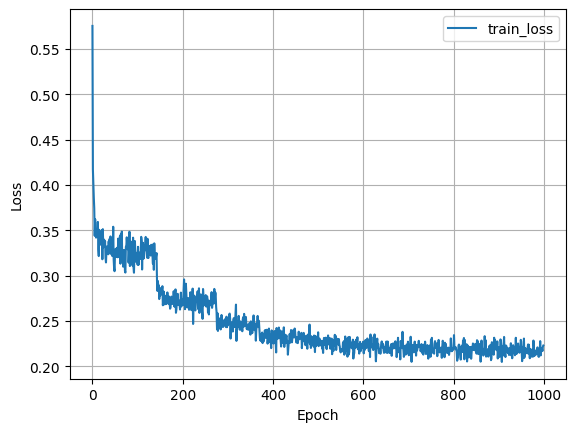

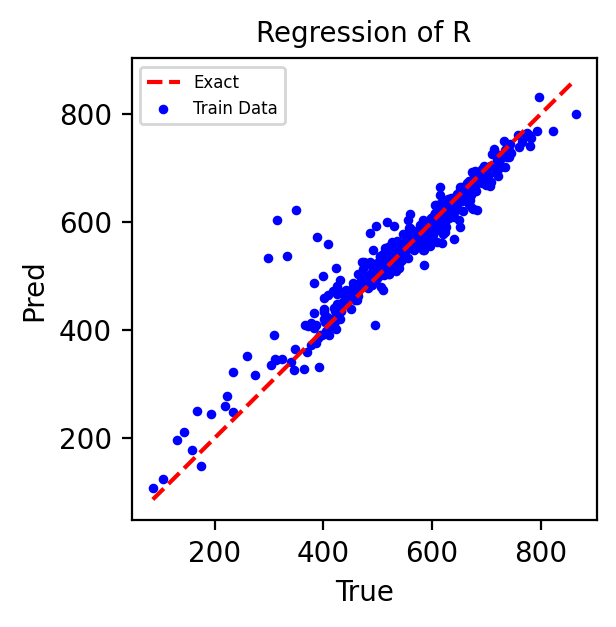

Data MAE (non-normalized): 18.8159098110885
Data RMSE (non-normalized): 33.06985673159787
Data MAPE (non-normalized): 4.2123953415374835
Data R2 (non-normalized): 0.9148407873054704
[  1.  32. 150. 203. 209.   0.   0.]
[ 6.18474336 10.98747541 15.04751431 19.77273743 21.85018917         nan
         nan]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


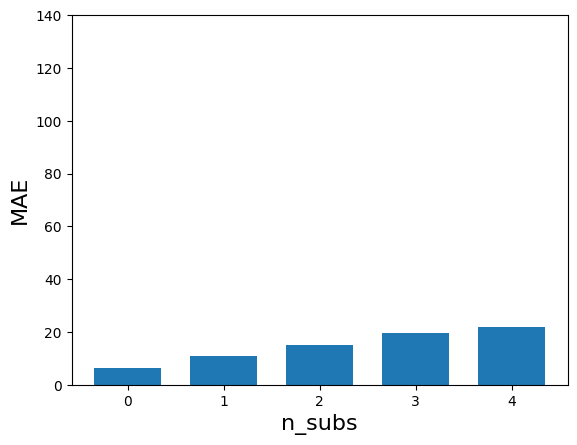

1B_0/kernel:0 (5, 1)
1B_1/kernel:0 (5, 1)
1B_2/kernel:0 (5, 1)
1B_3/kernel:0 (5, 1)
1B_4/kernel:0 (5, 1)
1B_5/kernel:0 (5, 1)
1B_6/kernel:0 (5, 1)
1B_7/kernel:0 (5, 1)
dense_20/kernel:0 (16, 512)
dense_20/bias:0 (512,)
dense_21/kernel:0 (512, 1)
dense_21/bias:0 (1,)

Pos0: [-12.00015  251.35367  231.28746  210.76971  102.239265]
Pos1: [  17.166061   86.73701   -68.22298  -134.5522   -140.80446 ]
Pos2: [-21.193644 -31.775246  92.20709  107.3668   134.12955 ]
Pos3: [  19.06099   -30.209635 -102.665306 -111.57899  -176.3234  ]
Pos4: [  22.262075  -23.47195  -109.58522  -126.5435   -160.7789  ]
Pos5: [-13.202371  49.38796   77.04811   96.54025  158.6038  ]
Pos6: [-16.147007  55.252346  97.7411   127.630035 158.69008 ]
Pos7: [-18.694695  69.91707   68.30386   95.08326  129.04485 ]


In [19]:
# Build a model training with all available data

epochs = 1000
batch_size = 4
learning_rate = 0.01
n_crossvalidation = 10

# 1. Build and compile 1-body model
model = model_Nb(learning_rate=learning_rate)
    
# 2. Train the model
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,
                                                 patience=50, min_lr=1e-8)
history = model.fit(x=x_data, y=y_data, epochs=epochs, batch_size=batch_size, callbacks=[reduce_lr], verbose=2)

# Plot the loss
plt.plot(history.history['loss'], label='train_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
train_loss_per_epoch = history.history['loss']
best_epoch = train_loss_per_epoch.index(min(train_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

# 3. Save the model
model.save('./Models/R_model_invariant_1body_TrainingAllData')
    
# 4. Evaluate the model with non-normalized units on the whole dataset

y_pred_data = model.predict(x_data)
y_true_data = np.zeros((len(y_data),1))
y_true_data[:,0] = y_data[:]

y_true_data = y_true_data * R_std + R_mean
y_pred_data = y_pred_data * R_std + R_mean
y_true_data = y_true_data.ravel()
y_pred_data = y_pred_data.ravel()

# Plot pred vs true
plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_data,y_pred_data,color="blue",label="Train Data",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

# 5. Compute metrics on non-normalized units
data_mae = mean_absolute_error(y_true_data,y_pred_data)
print("Data MAE (non-normalized): "+str(data_mae))
data_mse = mean_squared_error(y_true_data,y_pred_data,squared=False)
print("Data RMSE (non-normalized): "+str(data_mse))
data_mape = mean_absolute_percentage_error(y_true_data,y_pred_data)*100
print("Data MAPE (non-normalized): "+str(data_mape))
data_r2 = r2_score(y_true_data,y_pred_data)
print("Data R2 (non-normalized): "+str(data_r2))

# 6. Compute error for different nsubs on test set
error_nsubs = error_vs_nsubs(x_data, y_pred_data, y_true_data)
    
# 7. 1-body coefficients
names = [weight.name for layer in model.layers for weight in layer.weights]
weights = model.get_weights()
for name, weight in zip(names, weights):
    print(name, weight.shape)
print()
for i in range(8):
    print('Pos'+str(i)+': '+str(weights[i].flatten()*R_std))